# Network Science (HS21)
## Assignment 6

### Ben     Murphy          16-714-925
### Florian Rüegsegger      14-714-737

#### The excercise was solved together in person



In [26]:
import os
import networkx as nx
import re
from networkx import read_graphml
from NEMtropy import UndirectedGraph, DirectedGraph
from NEMtropy.network_functions import build_adjacency_from_edgelist
import numpy as np
from typing import Dict
import matplotlib.pyplot as plt


In [42]:
def fit_and_sample_cm(graph: nx.Graph,cm_class, model, name: str):
    adj_matrix = nx.to_numpy_array(graph)
    graph = cm_class(adj_matrix)
    graph.solve_tool(model=model)
    graph.ensemble_sampler(10,cpu_n=1, output_dir=f"samples/{graph.__class__.__name__}/{name}/")


def get_data(graph: nx.Graph, name: str, skip_sampling):
    if not skip_sampling:
        fit_and_sample_cm(graph, UndirectedGraph,"cm_exp",name)
        fit_and_sample_cm(graph, DirectedGraph,"dcm_exp", name)
    clusterings = []
    reciprocities = []
    for i in range(10):
        edgelist = np.loadtxt(f"samples/DirectedGraph/{name}/{i}.txt")
        net = nx.Graph()
        net.add_edges_from(edgelist)
        clusterings.append(nx.average_clustering(net))
        reciprocities.append(nx.reciprocity(net))

    return np.mean(clusterings), np.mean(reciprocities)


def plot_data(x,y,label):
    plt.plot(x, y, label=label)

def solve01(graphs: Dict,skip_sampling=False):
    clusters_og = []
    recip_og = []
    clusters_model = []
    recip_model = []
    
    keys = sorted([key for key in graphs.keys()])
    for key in keys:
        clusters_og.append(nx.average_clustering(graphs[key]))
        recip_og.append(nx.reciprocity(graphs[key]))

        data = get_data(graphs[key], key, skip_sampling)
        clusters_model.append(data[0])
        recip_model.append(data[1])
    
    plot_data(keys, clusters_og, "clusters_og")
    plot_data(keys, clusters_model, "clusters_model")
    plot_data(keys, recip_og, "recip_og")
    plot_data(keys, recip_model, "recip_model")
    plt.legend()
    plt.show()







solution error = 6.176398201773736e-07

solution error = 1.158404927537049e-09

solution error = 6.02545924266451e-09

solution error = 2.4270718768093502e-09

solution error = 1.1892647933109401e-07

solution error = 2.815024657820686e-09

solution error = 1.0502479881324689e-06

solution error = 3.5610412396636093e-09

solution error = 2.778542835812914e-06

solution error = 2.7225404153341515e-09

solution error = 9.425052382994181e-08

solution error = 1.8193588857684517e-09

solution error = 1.6240122278077251e-06

solution error = 2.394415332673816e-09

solution error = 2.956141997856321e-10

solution error = 2.7416149350756314e-09

solution error = 1.1825292745015759e-08

solution error = 3.4204781229618675e-09

solution error = 2.4829631684042397e-09

solution error = 5.636824340626845e-09

solution error = 3.628613853834395e-09

solution error = 3.2628406643198105e-09


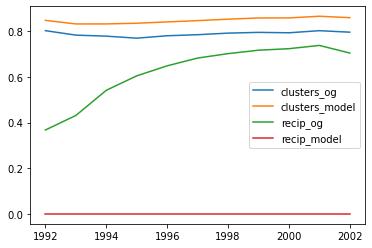

In [43]:
solve01(data,skip_sampling=True)

In [32]:
data_paths = os.listdir('data/')
data = {}
regex = re.compile(r'\d+')
for data_path in data_paths:
    year = regex.findall(data_path)
    data[int(year[0])] = read_graphml('data/' + data_path)

In [5]:
average_clustering_dict = {}
reciprocity_dict = {}
for key in data.keys():
    average_clustering_dict[key] = nx.average_clustering(data[key])
    reciprocity_dict[key] = nx.reciprocity(data[key])
    

In [4]:
adj_matrix_dict = {}
for key in data.keys():
    adj_matrix_dict[key] = nx.to_numpy_array(data[key])

In [24]:
undirected_graph_dict = {}
for key in adj_matrix_dict.keys():
    undirected_graph_dict[key] = data[key].to_undirected()

In [36]:
directed_graph_dict = {}
for key in adj_matrix_dict.keys():
    directed_graph_dict[key] = nx.Graph(adj_matrix_dict[key])

In [37]:
directed_average_clustering_dict = {}
directed_reciprocity_dict = {}
for key in directed_graph_dict.keys():
    directed_average_clustering_dict[key] = nx.average_clustering(directed_graph_dict[key])
    directed_reciprocity_dict[key] = nx.reciprocity(directed_graph_dict[key])

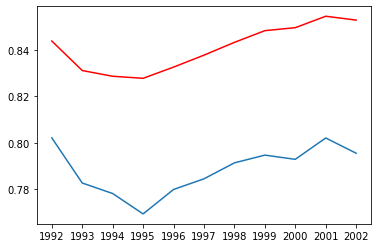

In [45]:
plt.plot(directed_average_clustering_dict.keys(),directed_average_clustering_dict.values(), color='red')
plt.plot(average_clustering_dict.keys(),average_clustering_dict.values())
